In [1]:
%load_ext autoreload
%autoreload 2
import sys
import pyccl as ccl
import numpy as np
from multiprocessing import Pool
import emcee
import matplotlib.pyplot as plt
import time
import pickle
import logging
import argparse
def binning(edges): return [[edges[i],edges[i+1]] for i in range(len(edges)-1)]

sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/modules/')
import model_completeness as comp
import model_purity as pur
import model_halo_mass_function as hmf
import class_richness_mass_relation as rm_relation
import model_halo_abundance as cl_count
import model_stacked_cluster_mass as cl_mass
import pinocchio_mass_richness_relation as sim_mr_rel
import class_likelihood as likelihood
import pinocchio_binning_scheme as binning_scheme
import cluster_abundance_covariance as cl_covar

In [2]:
def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [3]:
# cosmology
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711

cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

In [4]:
clc = cl_count.ClusterAbundance()
#choose the halo mass function and mass definition
massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=massdef)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25) * 4 * np.pi
clc.f_sky = clc.sky_area/(4*np.pi)
z_grid = np.linspace(0.2, 1., 500)
logm_grid = np.linspace(14.3, 15.5, 501)
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)

In [5]:
Z_bin, logMass_bin = binning_scheme.Z_bin, binning_scheme.LogMass_bin
N = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')

In [6]:
halobias_fct = ccl.halos.hbias.tinker10.HaloBiasTinker10(mass_def=massdef)#, mass_def_strict=True)

In [7]:
clc.compute_halo_bias_grid_MZ(z_grid = z_grid, logm_grid = logm_grid, halobiais = halobias_fct)
NHalo_bias = clc.Nhalo_bias_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')

# Compute SSC

In [8]:
CLCovar = cl_covar.Covariance_matrix()
Sij_partialsky_full_sky_rescaled_approx = CLCovar.compute_theoretical_Sij(Z_bin, cosmo, clc.f_sky, S_ij_type = 'full_sky_rescaled_approx')

In [9]:
Sij_partialsky_full_sky_rescaled = CLCovar.compute_theoretical_Sij(Z_bin, cosmo, clc.f_sky, S_ij_type = 'full_sky_rescaled')

In [10]:
path_to_mask = "../../data/pinocchio_mask_map_sky_coverage/pinocchio_mask_map_sky_coverage.fits"

In [11]:
Sij_partialsky_exact = CLCovar.compute_theoretical_Sij(Z_bin, cosmo, clc.f_sky, S_ij_type = 'exact', path = path_to_mask)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


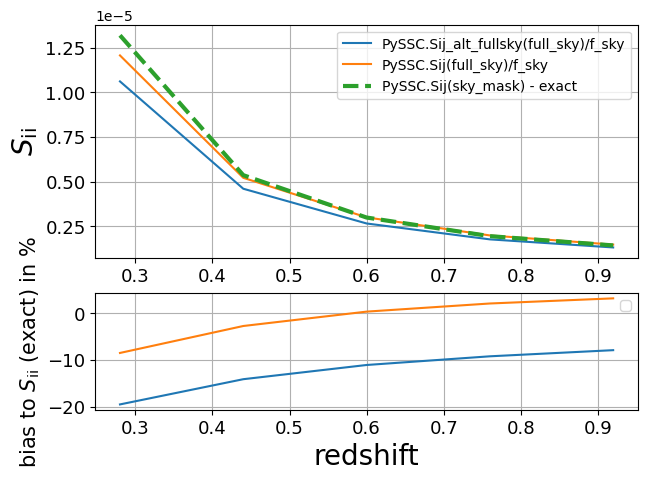

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(7,5), gridspec_kw={'height_ratios': [2,1]})
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=None)
ax[0].plot(np.mean(Z_bin, axis=1), Sij_partialsky_full_sky_rescaled_approx.diagonal(), label = 'PySSC.Sij_alt_fullsky(full_sky)/f_sky')
ax[0].plot(np.mean(Z_bin, axis=1), Sij_partialsky_full_sky_rescaled.diagonal(), label = 'PySSC.Sij(full_sky)/f_sky')
ax[0].plot(np.mean(Z_bin, axis=1), Sij_partialsky_exact.diagonal(), label = 'PySSC.Sij(sky_mask) - exact', ls='--', lw=3)
ax[0].set_ylabel(r'$S_{\rm ii}$', fontsize=20,)
#ax[0].xlabel(r'redshift', fontsize=20,)

ax[1].plot(np.mean(Z_bin, axis=1), 100*(Sij_partialsky_full_sky_rescaled_approx.diagonal() - Sij_partialsky_exact.diagonal())/Sij_partialsky_exact.diagonal())
ax[1].plot(np.mean(Z_bin, axis=1), 100*(Sij_partialsky_full_sky_rescaled.diagonal() - Sij_partialsky_exact.diagonal())/Sij_partialsky_exact.diagonal())
ax[1].set_ylabel(r'bias to $S_{\rm ii}$ (exact) in %', fontsize=15,)
ax[1].set_xlabel(r'redshift', fontsize=20,)

for j in range(2):
    ax[j].grid(which='both')
    ax[j].legend()
    ax[j].tick_params(axis='both', which = 'major', labelsize= 13)

In [13]:
Sij_which = Sij_partialsky_exact

In [14]:
Sample_covariance = CLCovar.sample_covariance_full_sky(Z_bin, logMass_bin, NHalo_bias, Sij_which)

In [15]:
Sbb = CLCovar.sample_covariance_full_sky(Z_bin, logMass_bin, NHalo_bias/N, Sij_which)

In [16]:
def run_simulation(N, delta = False):
    N_mean = N
    if delta:
        b_delta_SSC = np.random.multivariate_normal( mean = np.zeros(len(Z_bin)*len(logMass_bin)) ,
                                               cov = Sbb ).reshape(len(Z_bin),len(logMass_bin))
        N_obs = np.random.poisson(N_mean*(1 + b_delta_SSC))
    else:
        dN_SSC = np.random.multivariate_normal( mean = np.zeros(len(Z_bin)*len(logMass_bin)) ,
                                               cov = Sample_covariance  ).reshape(len(Z_bin),len(logMass_bin))
        N_obs = np.random.poisson(N_mean + dN_SSC)
    return N_obs

In [17]:
N_obs_list = []
for i in range(100000):
    N_obs_list.append(run_simulation(N))

In [18]:
data = load(f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_data_vector/data_vector_pinocchio_mock_mass-redshift_bins.pkl')

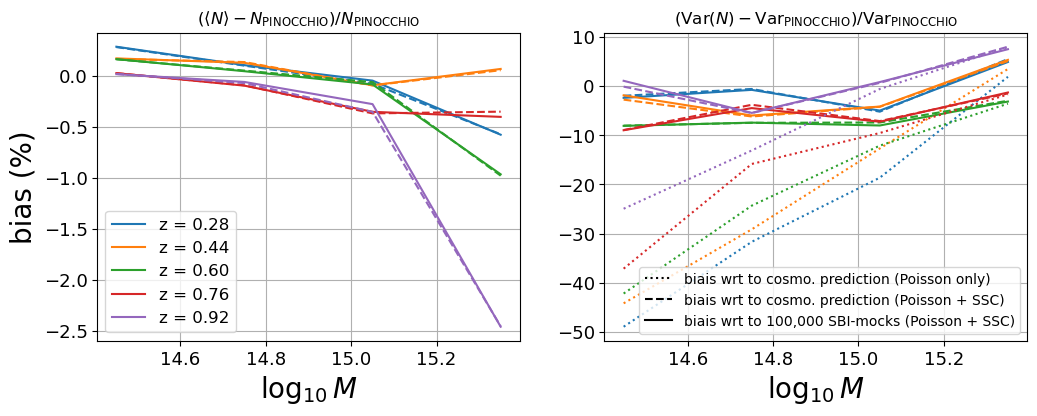

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121)

for i in range(len(Z_bin)):
    from_sim = np.mean(np.array(N_obs_list).T[:,i], axis=1)
    from_pred = N[i,:]
    from_pinocchio = data['mean_count_mass_redshift'].T[i,:]
    plt.plot(np.mean(logMass_bin, axis=1), 100*(from_sim-from_pinocchio)/from_pinocchio, '-'+'C' + str(i), label = 'z = '+f'{np.mean(Z_bin[i]):.2f}')
    plt.plot(np.mean(logMass_bin, axis=1), 100*(from_pred-from_pinocchio)/from_pinocchio, '--' + 'C' + str(i))
plt.title(r'$(\langle N \rangle - N_{\rm PINOCCHIO})/N_{\rm PINOCCHIO}$')
plt.ylabel('bias (%)', fontsize=20,)
plt.xlabel(r'$\log_{10}M$', fontsize=20,)
plt.grid(which='both')
plt.tick_params(axis='both', which = 'major', labelsize= 13)
plt.legend(fontsize=12)

plt.subplot(122)
plt.title(r'$(\mathrm{Var}( N ) - \mathrm{Var}_{\rm PINOCCHIO})/\mathrm{Var}_{\rm PINOCCHIO}$')
for i in range(len(Z_bin)):
    from_sim = np.std(np.array(N_obs_list).T[:,i], axis=1)**2
    from_pred = N[i,:] + Sample_covariance.diagonal()[i*len(logMass_bin):(i+1)*len(logMass_bin)]
    from_pred_poiss = N[i,:]
    from_pinocchio = (data['err_mean_count_mass_redshift'].T[i,:]**2)
    plt.plot(np.mean(logMass_bin, axis=1), 100*(from_sim-from_pinocchio)/from_pinocchio, '-'+'C' + str(i))
    plt.plot(np.mean(logMass_bin, axis=1), 100*(from_pred-from_pinocchio)/from_pinocchio, '--' + 'C' + str(i))
    plt.plot(np.mean(logMass_bin, axis=1), 100*(from_pred_poiss-from_pinocchio)/from_pinocchio, ls='dotted' , color= 'C' + str(i))
    
plt.plot([], [], ls='dotted', color='k', label = 'biais wrt to cosmo. prediction (Poisson only)')
plt.plot([], [], '--k', label = 'biais wrt to cosmo. prediction (Poisson + SSC)')
plt.plot([], [], '-k', label = 'biais wrt to 100,000 SBI-mocks (Poisson + SSC)')
plt.legend()

plt.xlabel(r'$\log_{10}M$', fontsize=20,)
plt.grid(which='both')
plt.tick_params(axis='both', which = 'major', labelsize= 13)